# Intialization

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.optim import lr_scheduler
import torch.optim as optim
import os, cv2, random
from torchvision import transforms
# Set up the network and training parameters
from networks import ClassificationNet, ModelM3
import pickle
from matplotlib import pyplot as plt

import numpy as np
from embeddings_utils import extract_dict_retrieval, extract_embeddings, getDistances, plot_embeddings, build_knn
from MITSplitDataSet import MITSplitDataSet
from trainer import train, test

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5] ) 
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #For imagenet pretrained
])

TRAIN_DATA_PATH = "../MIT_split/train/"
TEST_DATA_PATH = "../MIT_split/test/"

batch_size = 64

TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4275, 0.4525, 0.4494],
                         std=[0.2566, 0.2470, 0.2764])
    ])

train_data = ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
test_data = ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)

cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, **kwargs)


In [3]:
n_classes = 8
mit_classes = ['coast', 'forest', 'highway', 'inside_city', 'mountain',
                         'Opencountry', 'street', 'tallbuilding']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',]

Train or load model

In [4]:
embedding_net = ModelM3()
model = ClassificationNet(embedding_net, n_classes).to(device)

save_path = 'first_WEEK_model_trained2.pth'
if not os.path.exists(save_path):
    loss_fn = torch.nn.CrossEntropyLoss()
    lr = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for t in range(50):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loss, train_acc = train(train_loader, model, loss_fn, optimizer)
        test_loss, test_acc = test(test_loader, model, loss_fn)
    torch.save(model.state_dict(), save_path)
else:
    print('Loading model...')
    model.load_state_dict(torch.load(save_path))
    model.to(device)

Loading model...


Create embedings

In [5]:
embs, labels = extract_embeddings(train_loader, model, 256)
embs_test, labels_test = extract_embeddings(test_loader, model, 256)

# Visualize embeddings
## PCA

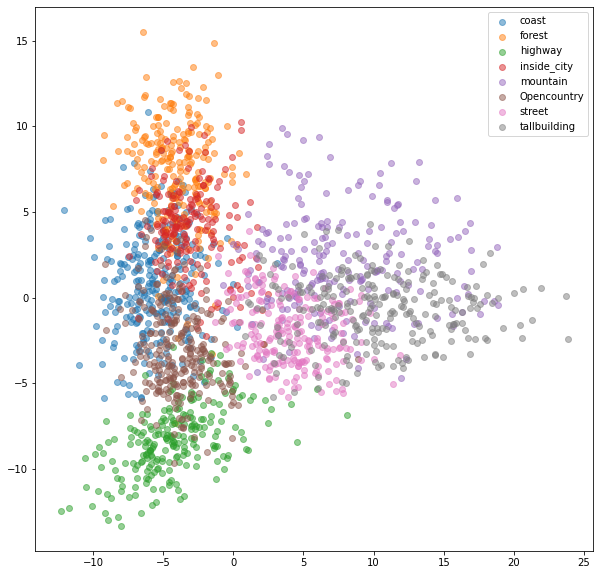

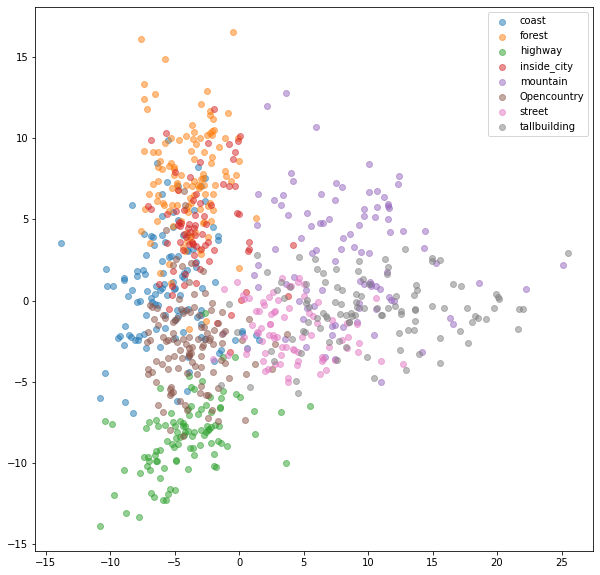

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
components = pca.fit_transform(embs)

#train embeddings
plot_embeddings(components, labels, mit_classes, colors)

#test embedings
test_comp = pca.transform(embs_test)
plot_embeddings(test_comp, labels_test, mit_classes, colors)

## LDA

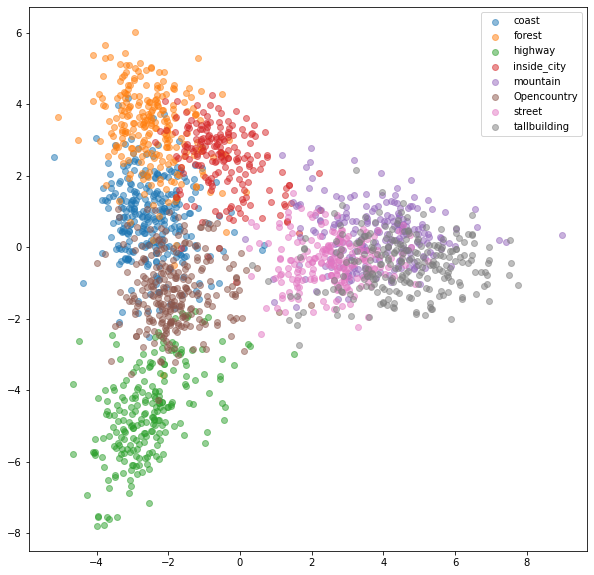

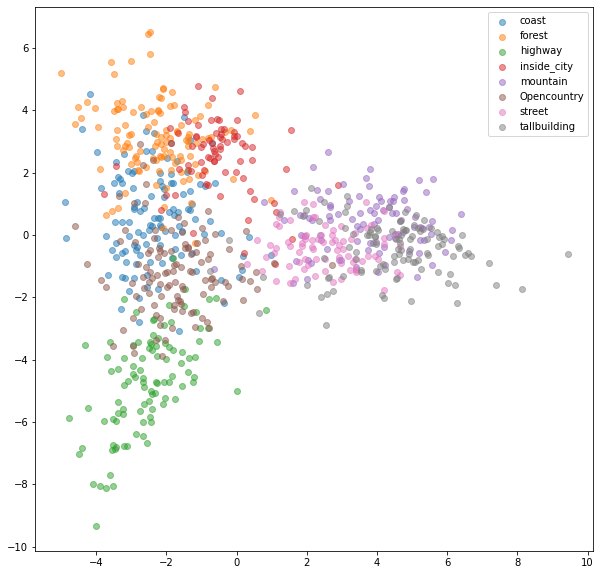

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda_embs = lda.fit_transform(embs, labels)

#train embeddings
plot_embeddings(lda_embs,labels, mit_classes, colors)

#test embeddings
lda_embs_test = lda.transform(embs_test)
plot_embeddings(lda_embs_test,labels_test, mit_classes, colors)

# KNN Classifier
Basic KNN classifier to evaluete the whole system

In [9]:
knn = build_knn(embs, labels, n_classes)
print(100.0 * knn.score(embs_test,labels_test))

86.61710037174721


One Vs Rest approach to estimate precision recall curves and average precision per class

In [10]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.neighbors import KNeighborsClassifier

Y = label_binarize(labels, classes=[*range(n_classes)])
Y_test = label_binarize(labels_test, classes=[*range(n_classes)])

clf = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=8))
clf.fit(embs, Y)

y_score = clf.predict_proba(embs_test)

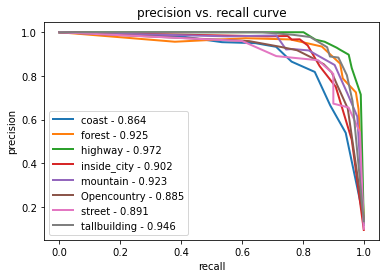

In [11]:
# precision recall curve
precision = dict()
recall = dict()
for i in range(n_classes):
    ap = average_precision_score(Y_test[:, i], y_score[:, i])
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label=f'{mit_classes[i]} - {ap:.3f}')
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

# Retrieval system

In [5]:
TRAIN_PATH = '../MIT_split/train_images_filenames.dat'
TRAIN_LABELS_DATA_PATH = '../MIT_split/train_labels.dat'
TEST_PATH = '../MIT_split/test_images_filenames.dat'
TEST_LABELS_DATA_PATH = '../MIT_split/test_labels.dat'
train_data2 = MITSplitDataSet(TRAIN_PATH, TRAIN_LABELS_DATA_PATH, TRANSFORM_IMG)
test_data2 = MITSplitDataSet(TEST_PATH, TEST_LABELS_DATA_PATH, TRANSFORM_IMG)

cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader2 = DataLoader(train_data2, batch_size=64, shuffle=True, **kwargs)
test_loader2 = DataLoader(test_data2, batch_size=64, shuffle=True, **kwargs)


In [6]:

train_dicts, test_dicts = [], []
if not os.path.exists('train_embs_data.pkl'):
    train_dict = extract_dict_retrieval(train_loader2, model, 256)
    with open('train_embs_data.pkl','wb') as opf:
        pickle.dump(train_dict, opf)
else:
    with open('train_embs_data.pkl','rb') as opf:
       train_dicts = pickle.load(opf)

if not os.path.exists('test_embs_data.pkl'):
    test_dict = extract_dict_retrieval(test_loader2, model, 256)
    with open('test_embs_data.pkl','wb') as opf:
        pickle.dump(test_dict, opf)
else:
    with open('test_embs_data.pkl','rb') as opf:
       test_dicts = pickle.load(opf)


../MIT_split/test/street/bost56.jpg
../MIT_split/test/coast/bea39.jpg
../MIT_split/test/tallbuilding/a487067.jpg
../MIT_split/test/tallbuilding/a462057.jpg
../MIT_split/test/forest/for3.jpg


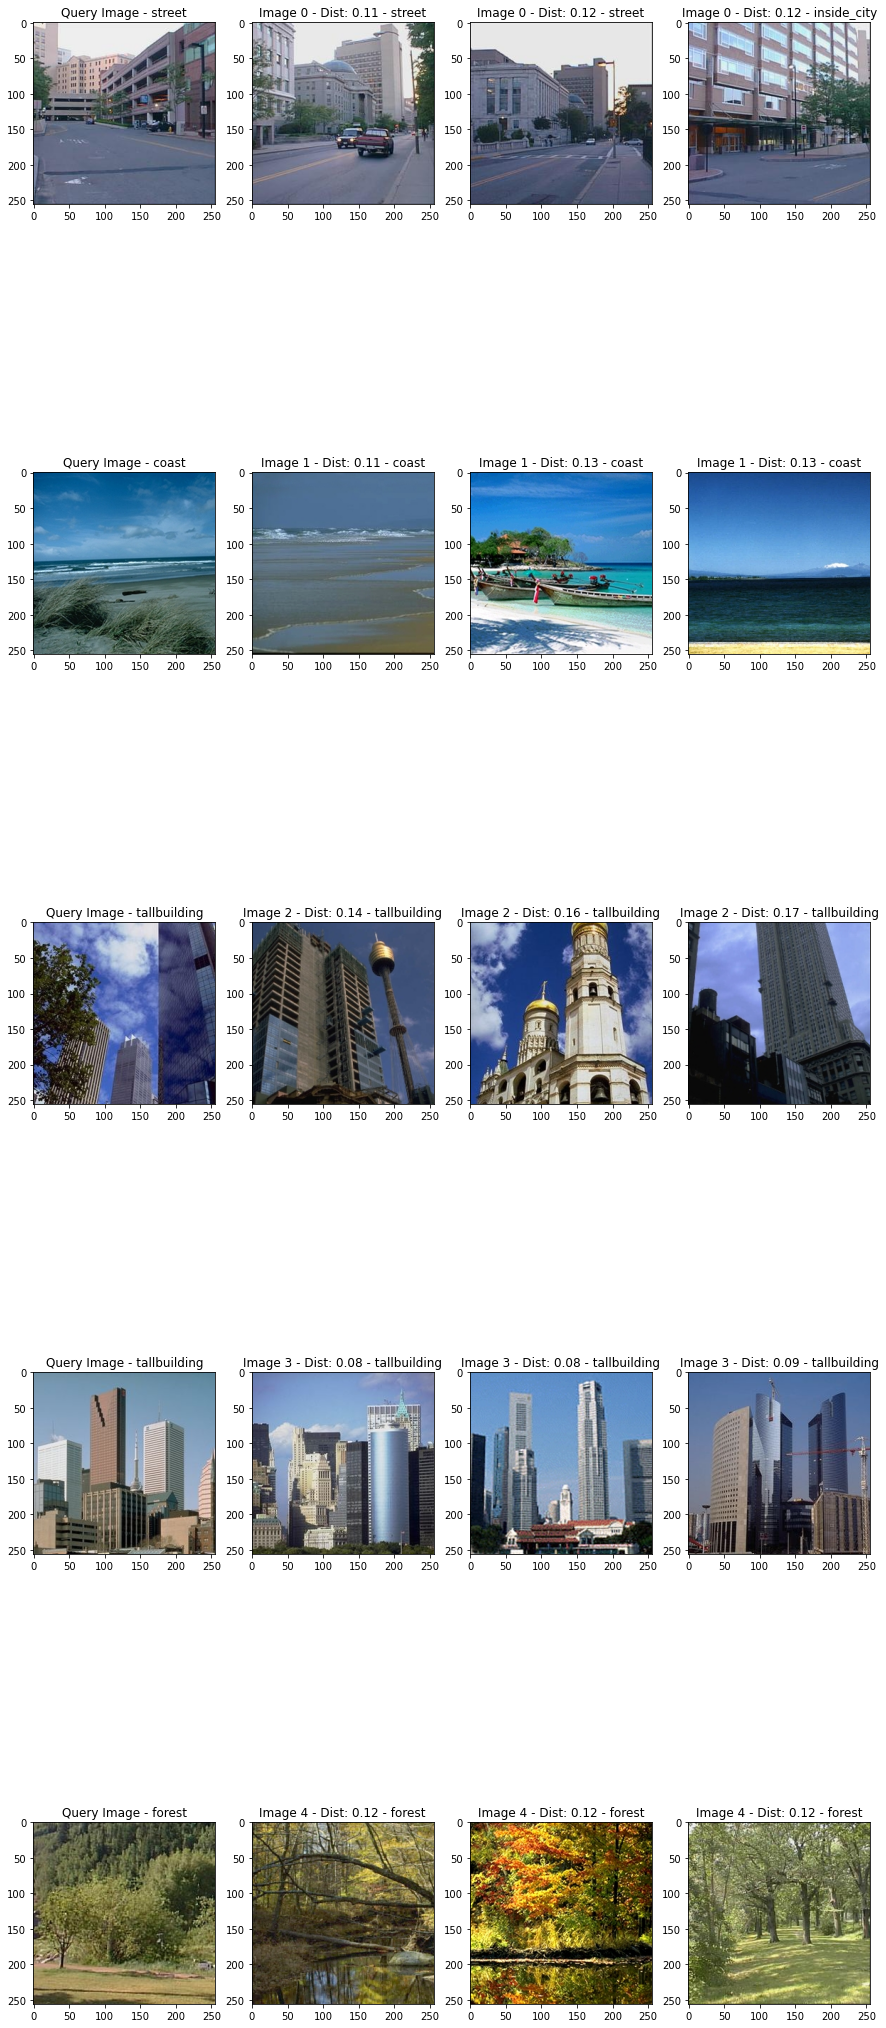

In [7]:
train_embs = [(f['path'],f['label'],f['emb']) for f in train_dicts]
fig, axs = plt.subplots(5, 4, figsize=(15,40))
random.shuffle(test_dicts)
for ind, elem in enumerate(test_dicts[:5]):
    print(elem['path'])
    im_query = cv2.cvtColor(cv2.imread(elem['path']), cv2.COLOR_BGR2RGB)
    axs[ind][0].imshow(im_query)
    axs[ind][0].set_title('Query Image - ' + elem['label'])

    results = getDistances(cv2.HISTCMP_BHATTACHARYYA, train_embs, elem['emb'])
    results = sorted([(v[1], v[0], k) for (k, v) in results.items()], reverse=False)

    for resInd, res in enumerate(results[:3]):
        im_aux = cv2.cvtColor(cv2.imread(res[2]), cv2.COLOR_BGR2RGB)
        axs[ind][resInd +1].imshow(im_aux)
        axs[ind][resInd +1].set_title(f'Image {ind} - Dist: {res[0]:.2f} - {res[1]}')

plt.show()
